# Pyroomacoustics Demo

### dependencies:  pyroomacoustics, pysoundfile, samplerate

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import soundfile

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

%matplotlib inline

import librosa
import librosa.display
import samplerate

import IPython.display as ipd

from scipy import signal

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

In [157]:
def plot_spec(spec, t_audio, frame_len, fs, hop=None):
    
    if hop is None:
        hop = frame_len
        
    fig, ax = plt.subplots(figsize=(20,7))
    spec = np.swapaxes(spec, 0 ,1)
    cax = ax.imshow(spec, interpolation=None, origin='lower', aspect='auto')
    ax.set_xlabel("Time [seconds]", fontsize=30)
    ax.set_ylabel("Frequency [Hz]", fontsize=30)
    x_labels = np.arange(max(t_audio), step=0.5)
    plt.xticks(x_labels*fs//hop, x_labels, fontsize=20)
    freqs = np.arange(frame_len//2+1) / frame_len * fs
    y_labels = np.arange(max(freqs)+1, step=1000).astype(np.int)
    plt.yticks(y_labels//(fs/frame_len), y_labels, fontsize=20)
    plt.tight_layout()

## Read file and show it in spectogram 

In [158]:
# get fs
data, fs = soundfile.read('./deep_voice/recordings/180910_142834.wav', stop=10)

In [159]:
data, fs = soundfile.read('./deep_voice/recordings/180910_142834.wav', start=231*fs, stop=245*fs)

In [160]:
data.shape

(617400, 2)

In [161]:
data = data[:,0]

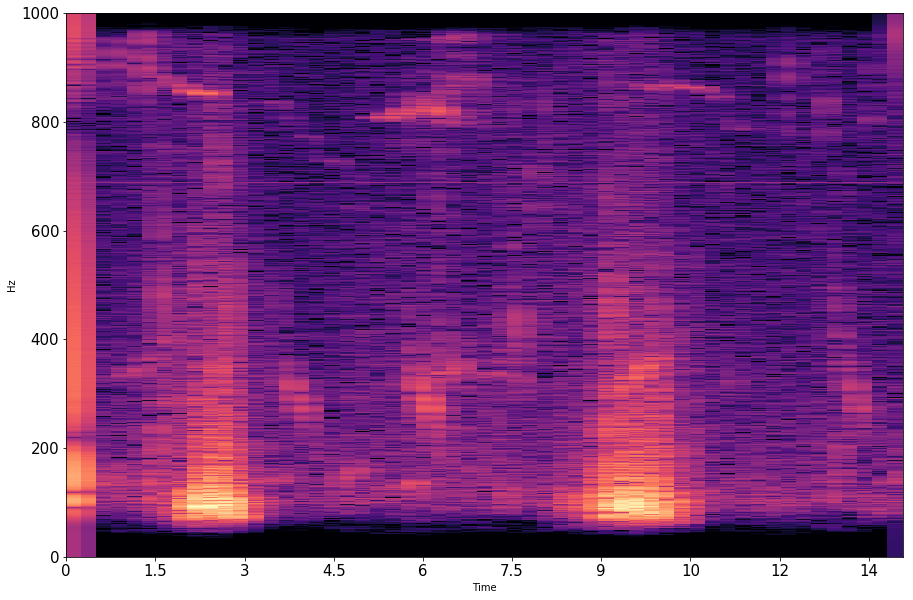

In [162]:
fmin=100
fmax = 2000
Gain = 25

# Simple API
ratio = fmax/(fs)
nfft=int(4096/2)
new_fs = int(fs*ratio)
converter = 'sinc_best'  # or 'sinc_fastest', ...
output_data_simple = samplerate.resample(data, ratio, converter)

sos = signal.butter(10, fmin, 'hp', fs=new_fs, output='sos')
output_data_simple = signal.sosfilt(sos, output_data_simple)

X = librosa.stft(output_data_simple, n_fft=nfft, hop_length=int(nfft/4.))

Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 10))
librosa.display.specshow(Xdb, sr=new_fs, x_axis='time', y_axis='hz', fmin=0, fmax=1000)

# ipd.Audio(output_data_simple, rate=new_fs)

soundfile.write('test.wav', 10**(Gain/20.)*output_data_simple,samplerate=new_fs)
# playsound('test.wav')

## Create room 

(<Figure size 432x288 with 1 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f12a0700f28>)

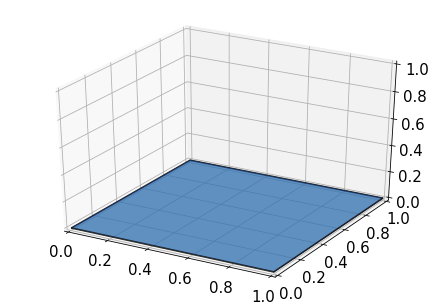

In [216]:
# room dimentions are in 1:10000 meters, so we can plot it easly
# max_order = amount of bounces I think
# absorption = absorption per bounce
# room is 10000m X 10000m X 50m - this is the sea
aroom = pra.ShoeBox([1, 1, 0.005], fs=fs, max_order=5, absorption=0.5)
aroom.plot()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(<Figure size 432x288 with 1 Axes>,
 <mpl_toolkits.mplot3d.axes3d.Axes3D at 0x7f12a060a3c8>)

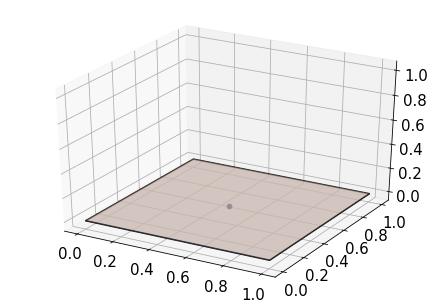

In [217]:
# add source at middle of room at depth 5 below surface
R_source = [0.5, 0.5, 0.0045] 
aroom.add_source(R_source, signal=data)

# Recievers are at 50 meters aside from source on X axis and at depth 5m and 10m  
R = np.c_[
    [0.5005, 0.5, 0.0045],  # mic 1
    [0.5005, 0.5, 0.0040],  # mic 2
    ]
mic_array = pra.MicrophoneArray(R, aroom.fs)

aroom.add_microphone_array(mic_array)
aroom.plot()

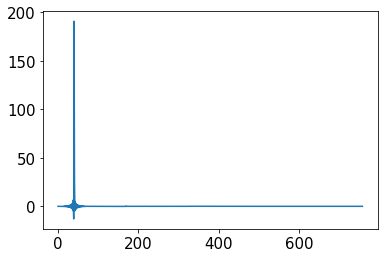

In [218]:
# show channel response

aroom.compute_rir()
plt.plot(aroom.rir[0][0])
plt.show()

## Run simulation

In [220]:
aroom.simulate()


In [221]:
# this is the result for each mike

aroom.mic_array.signals.shape

(2, 618158)

### note that aroom.mic_array.signals is normalized and not in original amplitude

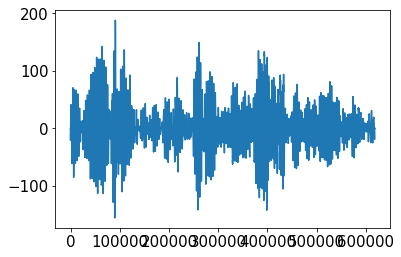

In [223]:
plt.plot(aroom.mic_array.signals[0,:])
plt.show()

# From here - it's your move

In [192]:
data_in_mic = aroom.mic_array.signals.T

In [193]:
fmin=100
fmax = 2000
Gain = 0

# Simple API
ratio = fmax/(fs)
nfft=int(4096/2)
new_fs = int(fs*ratio)
converter = 'sinc_best'  # or 'sinc_fastest', ...
output_data_simple = samplerate.resample(data_in_mic, ratio, converter)

sos = signal.butter(10, fmin, 'hp', fs=new_fs, output='sos')
output_data_simple = signal.sosfilt(sos, output_data_simple)



In [194]:
output_data_simple.shape

(28126, 2)

In [ ]:
X = librosa.stft(output_data_simple[:,0], n_fft=nfft, hop_length=int(nfft/4.))

Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 10))
librosa.display.specshow(Xdb, sr=new_fs, x_axis='time', y_axis='hz', fmin=0, fmax=1000)

# ipd.Audio(output_data_simple, rate=new_fs)

soundfile.write('test.wav', 10**(Gain/20.)*output_data_simple,samplerate=new_fs)
# playsound('test.wav')

CSSM
  Recovered azimuth: [288.] degrees
  Error: [72.] degrees


LinAlgError: singular matrix

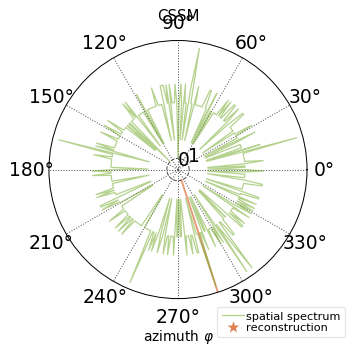

In [202]:
c = 1500/10000.    # speed of sound
nfft = 256  # FFT size
freq_bins = np.arange(5, 60)  # FFT bins to use for estimation


################################
# Compute the STFT frames needed
X = np.array([ 
    pra.stft(signal, nfft, nfft // 2, transform=np.fft.rfft).T 
    for signal in output_data_simple.T])

##############################################
# Now we can test all the algorithms available
algo_names = sorted(pra.doa.algorithms.keys())

for algo_name in algo_names:
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](R, new_fs, nfft, c=c, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_range=[fmin, fmax])

    doa.polar_plt_dirac()
    plt.title(algo_name)
    
    # doa.azimuth_recon contains the reconstructed location of the source
    print(algo_name)
    print('  Recovered azimuth:', doa.azimuth_recon / np.pi * 180., 'degrees')
    print('  Error:', circ_dist(0, doa.azimuth_recon) / np.pi * 180., 'degrees')

plt.show()
